# Customer Segmentation with K-Means Clustering

## Introduction

Effective customer segmentation is a crucial strategy for businesses to better understand their target audience and tailor their marketing efforts accordingly. In this case study, we will explore the application of K-Means clustering to segment customers based on their responses to various marketing offers. The data set can be downloaded from kaggle [here](https://www.kaggle.com/datasets/luizep/wine-kmc/data).

## Data Preparation

We begin by loading the necessary libraries and dataset, which contains information on marketing newsletters/e-mail campaigns and transaction-level data from customers. Our goal is to create a matrix that indicates whether each customer responded to a given offer, while handling any missing values appropriately.

In [1]:
import os
import warnings

# Suppress specific warnings
warnings.filterwarnings('ignore', category=UserWarning, module='openpyxl')
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn.cluster._kmeans", lineno=1436)

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import f_oneway
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Set Seaborn style and context
sns.set_style("whitegrid")
sns.set_context("poster")

# Set up the plotting environment
%matplotlib inline

In [2]:
df_offers = pd.read_excel("./WineKMC.xlsx", sheet_name=0)
df_offers.columns = ["offer_id", "campaign", "varietal", "min_qty", "discount", "origin", "past_peak"]
df_offers.head()

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
0,1,January,Malbec,72,56,France,False
1,2,January,Pinot Noir,72,17,France,False
2,3,February,Espumante,144,32,Oregon,True
3,4,February,Champagne,72,48,France,True
4,5,February,Cabernet Sauvignon,144,44,New Zealand,True


In [3]:
df_transactions = pd.read_excel("./WineKMC.xlsx", sheet_name=1)
df_transactions.columns = ["customer_name", "offer_id"]
df_transactions.head()

,customer_name,offer_id
0,Smith,2
1,Smith,24
2,Johnson,17
3,Johnson,24
4,Johnson,26


The `df_offers` dataset contains information about the various marketing offers or campaigns that were sent out to customers. Columns include:

- `offer_id`: A unique identifier for each offer
- `campaign`: The name of the marketing campaign the offer was part of
- `varietal`: The type of wine product associated with the offer
- `min_qty`: The minimum quantity of the product that the customer had to purchase to receive the offer
- `discount`: The discount percentage offered
- `origin`: The origin or region of the wine product
- `past_peak`: A boolean indicating whether the wine product was past its peak quality

The `df_transactions` dataset contains information about the customer transactions. Columns include:

- `customer_name`: The name of the customer
- `offer_id`: The unique identifier of the offer the customer responded to

Next, we pivot the data to create a matrix that indicates whether each customer responded to a given offer. This matrix will be the input for the K-Means clustering algorithm to identify distinct customer segments.



In [4]:
# Pivot the DataFrame
df_customers = df_transactions.pivot_table(index='customer_name', columns='offer_id', aggfunc=lambda x: 1, fill_value=0)
df_customers.head()

offer_id,1,2,3,4,5,6,7,8,9,10,...,23,24,25,26,27,28,29,30,31,32
customer_name,,,,,,,,,,,,,,,,,,,,,
Adams,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
Allen,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
Anderson,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
Bailey,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
Baker,0,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,1,0


## K-Means Clustering
The goal of the K-Means clustering analysis in this case study is to identify distinct segments or groups of customers based on their responses to the various marketing offers. K-Means is an unsupervised machine learning algorithm that partitions the data into K clusters, where each data point (customer) is assigned to the cluster with the nearest centroid.

The key steps in the K-Means clustering process are:

1. **Determine the Optimal Number of Clusters (K)**: Since the true number of customer segments is unknown, we need to determine the most appropriate value of K. We'll explore three common methods for this:

    - **Elbow Method**: Plotting the sum of squared distances (SSE) between data points and their assigned cluster centroids for different values of K, and identifying the "elbow" point where the SSE starts to diminish at a slower rate

    - **Silhouette Method**: Calculating the silhouette score, which measures how well each data point fits into its assigned cluster, and selecting the K that maximizes the average silhouette score.

    - **Gap Statistic Method**: Comparing the within-cluster dispersion for the observed data to the expected dispersion under a reference null distribution, and choosing the K that maximizes the gap statistic.

2. **Run K-Means Clustering with the Optimal K**: Once the optimal number of clusters is determined, we run the K-Means algorithm with the chosen K.

3. **Analyze Cluster Characteristics**: To understand the differences between the identified customer segments, the case study explores the distribution of various offer attributes (e.g., campaign, varietal, minimum quantity, discount, origin, past peak) across the clusters. This helps reveal the unique preferences and behaviors of each customer segment.

4. **Visualize Clusters**: Principal Component Analysis (PCA) is used to reduce the dimensionality of the data, allowing the customer segments to be visualized in a 2D space. This provides a graphical representation of how the customers are grouped based on their responses to the offers.

First, we'll start by determining the optimal number of clusters using the three methods.

### Elbow Method


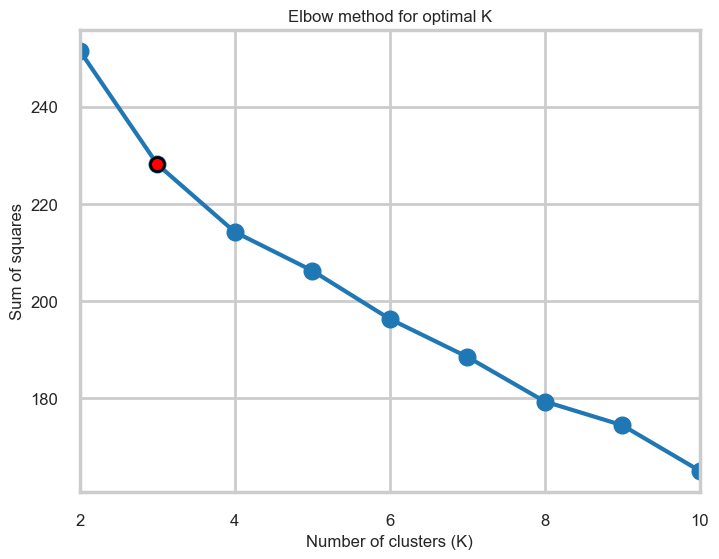

In [5]:
# Create a numpy matrix with only the columns representing the offers
x_cols = df_customers.to_numpy()

# Compute the sum of squared errors for each value of K
sse = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    kmeans.fit(x_cols)
    sse.append(kmeans.inertia_)

# Plot the sum of squared errors
plt.figure(figsize=(8, 6))
plt.plot(range(2, 11), sse, '-o')
plt.xlim(2, 10)
plt.xlabel('Number of clusters (K)', fontsize=12)
plt.ylabel('Sum of squares', fontsize=12)
plt.title('Elbow method for optimal K', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.scatter(3, sse[3 - 2], color='red', s=100, edgecolor='k', zorder=5)

plt.show()

From the elbow method, we can see that after K=3, the SSE starts to decline at a slower rate, indicating that K=3 clusters is the optimal number of clusters for this data set (although K=4 is also an option).


